In [1]:
import os
os.chdir('../')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_graphviz
from sklearn.linear_model import Lasso
from sklearn.externals import joblib
from urllib import urlencode
import matplotlib.pyplot as plt
import lib.yelp_api as yp
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import json
import re

%matplotlib inline

In [3]:
ylp_lacnty_df = pd.read_csv('data/tableau_cmplt_data.csv', index_col=0)

In [4]:
ylp_lacnty_df['max_rvw_dt'] = pd.to_datetime(ylp_lacnty_df['max_rvw_dt'])
ylp_lacnty_df['min_rvw_dt'] = pd.to_datetime(ylp_lacnty_df['min_rvw_dt'])

In [5]:
ylp_lacnty_df['max_rvw_yr'] = ylp_lacnty_df['max_rvw_dt'].apply(lambda x: x.year)
ylp_lacnty_df['min_rvw_yr'] = ylp_lacnty_df['min_rvw_dt'].apply(lambda x: x.year)

In [6]:
ylp_lacnty_df['min_rvw_yr'] = ylp_lacnty_df['min_rvw_yr'].fillna(value=0)
ylp_lacnty_df['max_rvw_yr'] = ylp_lacnty_df['max_rvw_yr'].fillna(value=0)
ylp_lacnty_df['avg_rating'] = ylp_lacnty_df['avg_rating'].fillna(value=0)

In [7]:
ylp_lacnty_df.head()

,bus_id,search_name,name,search_address,address_y,max_seats,risk_level,inspect_score,price,cat_1,...,latitude,longitude,num_reviews,avg_rating,min_rvw_dt,max_rvw_dt,est_rst_open,closed,max_rvw_yr,min_rvw_yr
4,dal-dae-po-los-angeles,#2 MOON BBQ,Dal Dae Po,478 N WESTERN AVE,478 N Western Ave,150,3,92.0,$,korean,...,34.079599,-118.308788,1.0,5.000000,2012-09-17,2012-09-17,0,False,2012.0,2012.0
5,moon-daepo-bbq-2-los-angeles,#2 MOON BBQ,Moon Daepo BBQ 2,478 N WESTERN AVE,478 N Western Ave,150,3,92.0,$$,korean,...,34.079609,-118.308664,553.0,2.806510,2012-04-29,2017-03-01,1767,False,2017.0,2012.0
9,1st-wok-los-angeles,1 WOK,1st Wok,5565 W MANCHESTER AVE,5565 W Manchester Ave,30,3,92.0,$,chinese,...,33.960025,-118.378183,42.0,3.857143,2010-03-21,2017-01-13,2490,False,2017.0,2010.0
14,trimana-los-angeles-17,10880 WILSHIRE TRIMANA,Trimana,10880 WILSHIRE BLVD,10880 Wilshire Blvd,60,3,98.0,$,sandwiches,...,34.058468,-118.442909,29.0,3.379310,2009-07-13,2017-02-08,2767,False,2017.0,2009.0
16,thai-silk-express-los-angeles,1632THAI SILK EXPRESS,Thai Silk Express,1260 S SOTO ST,1260 S Soto St,30,3,93.0,$,thai,...,34.026290,-118.219210,84.0,3.750000,2009-12-21,2017-03-03,2629,False,2017.0,2009.0


In [8]:
le = LabelEncoder()
ylp_lacnty_df['price'] = le.fit_transform(ylp_lacnty_df['price'].values)
ylp_lacnty_df['cat_1'] = le.fit_transform(ylp_lacnty_df['cat_1'].values)
ylp_lacnty_df['cat_2'] = le.fit_transform(ylp_lacnty_df['cat_2'].values)
ylp_lacnty_df['closed'] = le.fit_transform(ylp_lacnty_df['closed'].values)
ylp_lacnty_df['zip_code'] = le.fit_transform(ylp_lacnty_df['zip_code'].values)

/Users/annaheller/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


In [9]:
ylp_lacnty_df.head()

,bus_id,search_name,name,search_address,address_y,max_seats,risk_level,inspect_score,price,cat_1,...,latitude,longitude,num_reviews,avg_rating,min_rvw_dt,max_rvw_dt,est_rst_open,closed,max_rvw_yr,min_rvw_yr
4,dal-dae-po-los-angeles,#2 MOON BBQ,Dal Dae Po,478 N WESTERN AVE,478 N Western Ave,150,3,92.0,1,87,...,34.079599,-118.308788,1.0,5.000000,2012-09-17,2012-09-17,0,0,2012.0,2012.0
5,moon-daepo-bbq-2-los-angeles,#2 MOON BBQ,Moon Daepo BBQ 2,478 N WESTERN AVE,478 N Western Ave,150,3,92.0,2,87,...,34.079609,-118.308664,553.0,2.806510,2012-04-29,2017-03-01,1767,0,2017.0,2012.0
9,1st-wok-los-angeles,1 WOK,1st Wok,5565 W MANCHESTER AVE,5565 W Manchester Ave,30,3,92.0,1,35,...,33.960025,-118.378183,42.0,3.857143,2010-03-21,2017-01-13,2490,0,2017.0,2010.0
14,trimana-los-angeles-17,10880 WILSHIRE TRIMANA,Trimana,10880 WILSHIRE BLVD,10880 Wilshire Blvd,60,3,98.0,1,116,...,34.058468,-118.442909,29.0,3.379310,2009-07-13,2017-02-08,2767,0,2017.0,2009.0
16,thai-silk-express-los-angeles,1632THAI SILK EXPRESS,Thai Silk Express,1260 S SOTO ST,1260 S Soto St,30,3,93.0,1,135,...,34.026290,-118.219210,84.0,3.750000,2009-12-21,2017-03-03,2629,0,2017.0,2009.0


In [10]:
corr = ylp_lacnty_df.corr()

for i in corr:
    new_col = 'abs_{}'.format(i)
    corr[new_col] = [abs(x) for x in corr[i]]

corr_abs = corr[[col for col in corr if 'abs' in col]]
corr = corr[[col for col in corr if 'abs' not in col]]

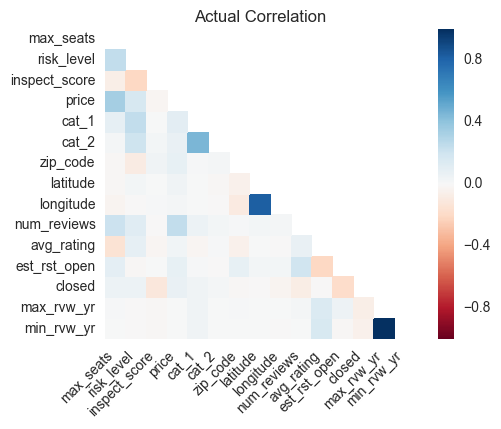

In [11]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 0)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, square=True, cmap='RdBu')
    plt.xticks(rotation=45, ha='right')
    plt.title('Actual Correlation')

In [12]:
X = ylp_lacnty_df[['price', 'cat_1', 'cat_2', 'zip_code',
                   'latitude', 'longitude', 'num_reviews', 
                   'avg_rating', 'min_rvw_yr', 'max_rvw_yr',
                   'est_rst_open']]
y = ylp_lacnty_df['closed']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [14]:
dtc = DecisionTreeClassifier()

In [15]:
dtc.fit(X_train, y_train)
dtc.score(X_train, y_train), dtc.score(X_test, y_test)

(1.0, 0.84036488027366019)

In [20]:
max_depth_ = range(1, 11, 1)
scores = []

for i in max_depth_:
    rf = RandomForestClassifier(max_depth=i)
    rf.fit(X_train, y_train)
    scores.append((i, rf.score(X_train, y_train)*100, 'train'))
    scores.append((i, rf.score(X_test, y_test)*100, 'test'))

In [21]:
scores = pd.DataFrame(scores)

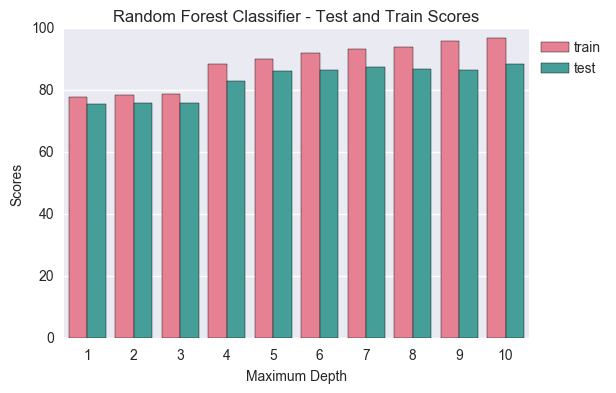

In [32]:
sns.barplot(x=0, y=1, hue=2, data=scores, palette='husl')
plt.xlabel('Maximum Depth', fontsize=10)
plt.ylabel('Scores', fontsize=10)
plt.title('Random Forest Classifier - Test and Train Scores')
plt.legend(bbox_to_anchor = (1, 1), loc = 2, handletextpad = 0.3, fontsize=10)
plt.show()